In [39]:
# Solve Poisson's equation -(uxx + uyy) = f, bnd cnds u(x,y) = g(x,y)
# on a square grid using the finite difference method.
#
# UC Berkeley Math 228B, Per-Olof Persson <persson@berkeley.edu>

using SparseArrays, Plots

"""
    A, b, x, y = assemblePoisson(n, f, g)

Assemble linear system Au = b for Poisson's equation using finite differences.
Grid size (n+1) x (n+1), right hand side function f(x,y), Dirichlet boundary
conditions g(x,y).
"""
function assemblePoisson(n, f, g)
    h = 1.0 / n
    N = (n+1)^2
    x = h * (0:n)
    y = x

    umap = reshape(1:N, n+1, n+1)     # Index mapping from 2D grid to vector
    A = Tuple{Int64,Int64,Float64}[]  # Array of matrix elements (row,col,value)
    b = zeros(N)

    # Main loop, insert stencil in matrix for each node point
    for j = 1:n+1
        for i = 1:n+1
            row = umap[i,j]
            if i == 1 || i == n+1 || j == 1 || j == n+1
                # Dirichlet boundary condition, u = g
                push!(A, (row, row, 1.0))
                b[row] = g(x[i],y[j])
            else
                # Interior nodes, 9-point stencil
                push!(A, (row, row, -20.0))
                push!(A, (row, umap[i+1,j], 4.0))
                push!(A, (row, umap[i-1,j], 4.0))
                push!(A, (row, umap[i,j+1], 4.0))
                push!(A, (row, umap[i,j-1], 4.0))
                push!(A, (row, umap[i-1,j-1], 1.0))
                push!(A, (row, umap[i-1,j+1], 1.0))
                push!(A, (row, umap[i+1,j-1], 1.0))
                push!(A, (row, umap[i+1,j+1], 1.0))
 
                b[row] = -6*h^2 * (f(x[i], y[j]) + 1/12 * (f(x[i+1],y[j]) + f(x[i-1],y[j]) +
                f(x[i],y[j+1]) + f(x[i],y[j-1]) - 4*f(x[i],y[j])))

            end
        end
    end

    # Create CSC sparse matrix from matrix elements
    A = sparse((x->x[1]).(A), (x->x[2]).(A), (x->x[3]).(A), N, N)

    return A, b, x, y
end

assemblePoisson

In [40]:
function plotit(x, y, u)
    # Plotting
    u = reshape(u, length(x), length(y))
    contour(x, y, u, 10, colors="k")
    contourf(x, y, u, 10)
    axis("equal")
    colorbar()
end

plotit (generic function with 1 method)

In [41]:
"""
    error = testPoisson(n=20)

Poisson test problem:
  - Prescribe exact solution uexact
  - set boundary conditions g = uexact and set RHS f = -Laplace(uexact)

Solves and plots solution on a (n+1) x (n+1) grid.
Returns error in max-norm.
"""
function testPoisson(n=40)
    uexact(x,y) = exp(-(4(x - 0.3)^2 + 9(y - 0.6)^2))
    f(x,y) = uexact(x,y) * (26 - (18y - 10.8)^2 - (8x - 2.4)^2)
    A, b, x, y = assemblePoisson(n, f, uexact)

    # Solve + reshape solution into grid array
    u = reshape(A \ b, n+1, n+1)
 
    # Compute error in max-norm
    u0 = uexact.(x, y')
    error = maximum(abs.(u - u0))
end

testPoisson

In [42]:
error = testPoisson(40)
println(error)

1.3028384358015899e-6


In [43]:
using Plots, Polynomials

function testConvergence(ns)
    errors = zeros(length(ns))
    hs = zeros(length(ns))
    for i in (1:length(ns))
        errors[i] = testPoisson(trunc(Int64,ns[i]))
        hs[i] = 1 / ns[i]
    end
    fit = Polynomials.fit(log.(hs), log.(errors), 1)
    order = coeffs(fit)[2]
    p = plot(hs, errors, xscale=:log10, yscale=:log10, xlabel="h", ylabel="error", label= "Order of convergence: $(order)")
    display(p)
end

testConvergence (generic function with 1 method)

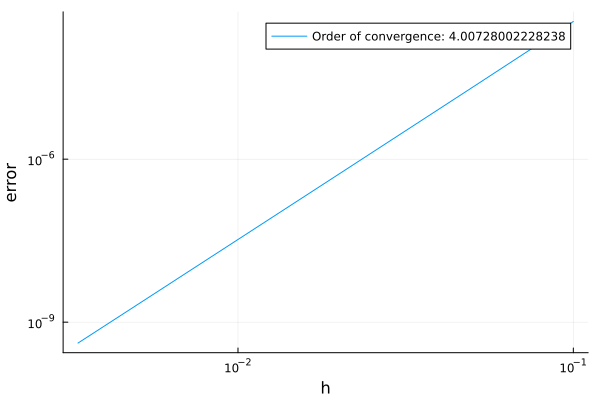

In [44]:
ns = [300, 200, 150, 100, 50, 20, 10]
testConvergence(ns)